In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
from math import pi
import folium
%matplotlib inline
import shapely
from shapely.geometry import *
import pysal as ps
import matplotlib.pylab as plt

In [2]:
blocks = gpd.read_file('Oakland_Blocks.shp').set_index('GEOID10')['geometry']

In [3]:
fips = ['060014010002001','060014010002002','060014010002010','060014010002012','060014010002003','060014010002011']
test1=blocks.loc[fips]
test1bg=test1.groupby(test1.index.str[:12]).agg(shapely.ops.unary_union)

test2fips=['060014013002004','060014013002009','060014013002007','060014013002005','060014013002002',
           '060014013002006','060014013002003',
           '060014013002008','060014013002000']
test2=blocks.loc[test2fips]
test2bg=test2.groupby(test2.index.str[:12]).agg(shapely.ops.unary_union)

test3fips=['060014010005008', '060014010005010', '060014010006011']
test3=blocks.loc[test3fips]
test3bg=test3.groupby(test3.index.str[:12]).agg(shapely.ops.unary_union)

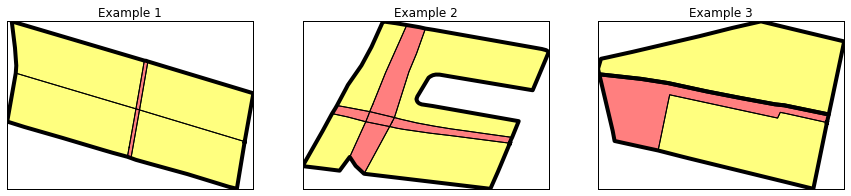

In [4]:
f, axes = plt.subplots(1,3, figsize=(15,3))
for i,(result, ax, bg) in enumerate(zip([test1, test2, test3], axes, [test1bg, test2bg, test3bg])):
    t=(result.area/result.length)>16
    a,b=result[t], result[~t]
    ax.set(xticks=[], yticks=[], title='Example {}'.format(str(i+1)))
    gpd.GeoSeries(bg).plot(ax=axes[i], linewidth=4, color='white')
    a.plot(ax=axes[i], color='yellow')
    b.plot(ax=axes[i], color='red')


In [42]:
#in addition to blocks, have truth input sequence and grouping

sliver_merge_mask = np.log(blocks.area/blocks.length)<2.9
bg_grouping = pd.Series(index=blocks.index, data=blocks.index.str[:12], name='BGFIPS')


In [39]:
def merge_polys(input_geos, merge_mask, constrain_groups=None):
    merge_polys = input_geos[merge_mask]
    full_polys = input_geos[~merge_mask]
    def gen_xwalk(poly):
        i=poly.name
        geo=poly.geometry
        if merge_mask.loc[i]:
            intersections = full_polys.intersection(geo)
            line_intersections = intersections.apply(lambda x:type(x)).isin([LineString, MultiLineString])
            touching = full_polys[line_intersections]
            try:
                cg = constrain_groups.loc[intersections.index]
                in_same_group = cg==constrain_groups.loc[i]
                possible_polys = full_polys[in_same_group & line_intersections]
            except:
                possible_polys = full_polys[line_intersections]

            if len(possible_polys)>0:
                return intersections.loc[possible_polys.index].length.idxmax()
            else:
                return np.nan
        else:
            return i
    poly_xwalk = pd.Series(pd.DataFrame(input_geos).apply(gen_xwalk,1), name='XWalk')
    merged_geo = gpd.GeoSeries(input_geos.groupby(poly_xwalk).agg(shapely.ops.unary_union), crs=input_geos.crs)

    return poly_xwalk, merged_geo

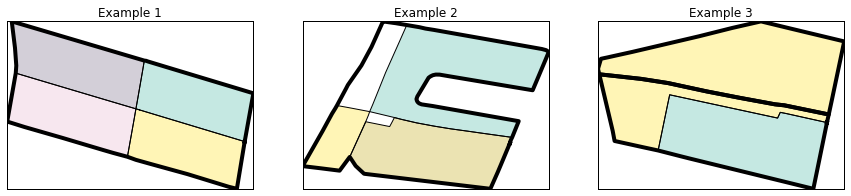

In [44]:
args=[(test1, sliver_merge_mask),(test2, sliver_merge_mask),(test3, sliver_merge_mask)] 
results = [merge_polys(*arg)[1] for arg in args]

f, axes = plt.subplots(1,3, figsize=(15,3))
for i,(result,ax, bg) in enumerate(zip(results, axes, [test1bg, test2bg, test3bg])):
    ax.set(xticks=[], yticks=[], title='Example {}'.format(str(i+1)))
    gpd.GeoSeries(bg).plot(ax=axes[i], linewidth=4, color='white')
    result.plot(ax=axes[i], cmap='Set3')


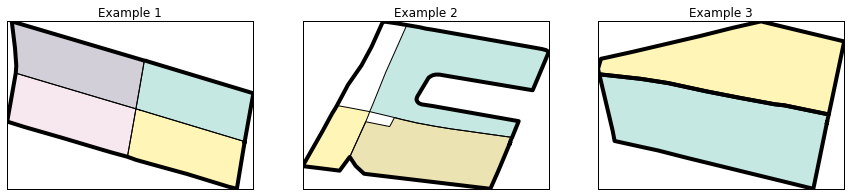

In [45]:
args=[(test1, sliver_merge_mask, bg_grouping),(test2, sliver_merge_mask, bg_grouping),(test3, sliver_merge_mask, bg_grouping)] 
results = [merge_polys(*arg)[1] for arg in args]

f, axes = plt.subplots(1,3, figsize=(15,3))
for i,(result,ax, bg) in enumerate(zip(results, axes, [test1bg, test2bg, test3bg])):
    
    ax.set(xticks=[], yticks=[], title='Example {}'.format(str(i+1)))
    gpd.GeoSeries(bg).plot(ax=axes[i], linewidth=4, color='white')
    result.plot(ax=axes[i], cmap='Set3')

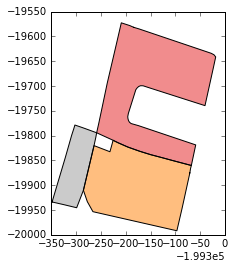

In [46]:
merge_polys(test2, sliver_merge_mask, bg_grouping)[1].plot()

In [10]:
test2

GEOID10
060014013002004    POLYGON ((-199605.0265586239 -19786.2953621111...
060014013002009    POLYGON ((-199648.7486184507 -19933.8094473956...
060014013002007    POLYGON ((-199566.3776585338 -19953.3520390903...
060014013002005    POLYGON ((-199560.4966561923 -19803.2633798103...
060014013002002    POLYGON ((-199554.741761177 -19775.93511499465...
060014013002006    POLYGON ((-199528.7262837254 -19820.5928204730...
060014013002003    POLYGON ((-199590.6188816926 -19735.4890568628...
060014013002008    POLYGON ((-199585.5726645145 -19910.3031755397...
060014013002000    POLYGON ((-199522.7584528946 -19791.7128525096...
Name: geometry, dtype: object

In [47]:
#changed version
def merge_polys_a(input_geos, merge_mask=sliver_merge_mask, constrain_groups=bg_grouping):
    merge_polys = input_geos[merge_mask]
    full_polys = input_geos[~merge_mask]
    def gen_xwalk(poly):
        i=poly.name
        geo=poly.geometry
        if merge_mask.loc[i]:
            intersections = full_polys.intersection(geo)
            line_intersections = intersections.apply(lambda x:type(x)).isin([LineString, MultiLineString])
            touching = full_polys[line_intersections]
            try:
                cg = constrain_groups.loc[intersections.index]
                in_same_group = cg==constrain_groups.loc[i]
                possible_polys = full_polys[in_same_group & line_intersections]
            except:
                possible_polys = full_polys[line_intersections]

            if len(possible_polys)>0:
                return intersections.loc[possible_polys.index].length.idxmax()
            else:
                return i
        else:
            return i
    poly_xwalk = pd.Series(pd.DataFrame(input_geos).apply(gen_xwalk,1), name='XWalk')
    merged_geo = gpd.GeoSeries(input_geos.groupby(poly_xwalk).agg(shapely.ops.unary_union), crs=input_geos.crs)
    return poly_xwalk, merged_geo

In [73]:
def merge_iterative(input_geos, merge_mask=sliver_merge_mask, constrain_groups=bg_grouping):
    xwalk, new_geo = merge_polys_a(input_geos, merge_mask = merge_mask, constrain_groups=constrain_groups)
    while merge_mask[new_geo.index].any():
        xwalk2,new_geo = merge_polys_a(new_geo, merge_mask = merge_mask, constrain_groups=constrain_groups)
    xwalk.update(xwalk2)
    return xwalk, new_geo

merge_iterative(test2)
    

(GEOID10
 060014013002004    060014013002009
 060014013002009    060014013002009
 060014013002007    060014013002007
 060014013002005    060014013002007
 060014013002002    060014013002000
 060014013002006    060014013002007
 060014013002003    060014013002000
 060014013002008    060014013002007
 060014013002000    060014013002000
 Name: XWalk, dtype: object, XWalk
 060014013002000    POLYGON ((-199484.1380602146 -19581.6935485955...
 060014013002007    POLYGON ((-199370.952304122 -19875.18714785855...
 060014013002009    POLYGON ((-199648.7486184507 -19933.8094473956...
 Name: geometry, dtype: object)

In [70]:
z

GEOID10
060014013002004    060014013002009
060014013002009    060014013002009
060014013002007    060014013002007
060014013002005    060014013002005
060014013002002    060014013002000
060014013002006    060014013002007
060014013002003    060014013002003
060014013002008    060014013002007
060014013002000    060014013002000
Name: XWalk, dtype: object

In [71]:
x

XWalk
060014013002000    060014013002000
060014013002003    060014013002000
060014013002005    060014013002007
060014013002007    060014013002007
060014013002009    060014013002009
Name: XWalk, dtype: object

In [72]:
z.update(x)
print z

GEOID10
060014013002004    060014013002009
060014013002009    060014013002009
060014013002007    060014013002007
060014013002005    060014013002007
060014013002002    060014013002000
060014013002006    060014013002007
060014013002003    060014013002000
060014013002008    060014013002007
060014013002000    060014013002000
Name: XWalk, dtype: object


In [ ]:
a=pd.Series(index=['A','B','C','D'])

In [12]:
def merge_polys_b(input_geos, merge_mask, constrain_groups=None):
    
    merge_polys = input_geos[merge_mask]
    full_polys = input_geos[~merge_mask]
    poly_xwalk = pd.Series(name='XWalk')
    for i, geo in input_geos.iteritems():
        if merge_mask.loc[i]:
            intersections = full_polys.intersection(geo)
            line_intersections = intersections.apply(lambda x:type(x)).isin([LineString, MultiLineString])
            touching = full_polys[line_intersections]
            try:
                cg = constrain_groups.loc[intersections.index]
                in_same_group = cg==constrain_groups.loc[i]
                possible_polys = full_polys[in_same_group & line_intersections]
            except:
                possible_polys = full_polys[line_intersections]

            if len(possible_polys)>0:
                r= intersections.loc[possible_polys.index].length.idxmax()
            else:
                r = i
                print "{} is unfixed sliver".format(i)
        else:
            r = i
        poly_xwalk.loc[i]=r
    merged_geo = gpd.GeoSeries(input_geos.groupby(poly_xwalk).agg(shapely.ops.unary_union), crs=input_geos.crs)
    return poly_xwalk, merged_geo
        

In [19]:

def merge_polys_c(input_geos, merge_mask, constrain_groups=None):
    
 
    #poly_xwalk = pd.Series(name='XWalk')
    f = gpd.GeoDataFrame(columns=['XWalk'], geometry=input_geos)
    f['XWalk']=input_geos.index
    while merge_mask[f['XWalk']].sum()>0: 

    
        merge_polys = f['geometry'][merge_mask]
        full_polys = f['geometry'][~merge_mask]
        
        for i, poly in f.iterrows():
            geo=poly['geometry']
            if merge_mask.loc[i]:
                intersections = full_polys.intersection(geo)
                line_intersections = intersections.apply(lambda x:type(x)).isin([LineString, MultiLineString])
                touching = full_polys[line_intersections]
                try:
                    cg = constrain_groups.loc[intersections.index]
                    in_same_group = cg==constrain_groups.loc[i]
                    possible_polys = full_polys[in_same_group & line_intersections]
                except:
                    possible_polys = full_polys[line_intersections]

                if len(possible_polys)>0:
                    r= intersections.loc[possible_polys.index].length.idxmax()
                else:
                    r = i
                    print "{} is unfixed sliver".format(i)
            else:
                r = i
            f.loc[i, 'XWalk']=r
    merged_geo = gpd.GeoSeries(input_geos.groupby(f.XWalk).agg(shapely.ops.unary_union), crs=input_geos.crs)
    return f['XWalk'], merged_geo

In [20]:
a=merge_polys_c(test2, merge_mask, bg_grouping)

060014013002005 is unfixed sliver
060014013002003 is unfixed sliver
060014013002005 is unfixed sliver
060014013002003 is unfixed sliver
060014013002005 is unfixed sliver
060014013002003 is unfixed sliver
060014013002005 is unfixed sliver
060014013002003 is unfixed sliver
060014013002005 is unfixed sliver
060014013002003 is unfixed sliver
060014013002005 is unfixed sliver
060014013002003 is unfixed sliver
060014013002005 is unfixed sliver
060014013002003 is unfixed sliver
060014013002005 is unfixed sliver
060014013002003 is unfixed sliver
060014013002005 is unfixed sliver
060014013002003 is unfixed sliver
060014013002005 is unfixed sliver
060014013002003 is unfixed sliver
060014013002005 is unfixed sliver
060014013002003 is unfixed sliver
060014013002005 is unfixed sliver
060014013002003 is unfixed sliver
060014013002005 is unfixed sliver
060014013002003 is unfixed sliver
060014013002005 is unfixed sliver
060014013002003 is unfixed sliver
060014013002005 is unfixed sliver
06001401300200

KeyboardInterrupt: 

In [ ]:
merge_mask.loc['060014013002009']

In [ ]:
merge_mask[a].sum()

In [ ]:
merge_polys_b(test2, merge_mask, bg_grouping)[0]

In [ ]:
test2.to_file('C:/Temp/test2.shp')

In [ ]:
should_restart = True
while should_restart:
  should_restart = False
  for i in xrange(10):
    print i
    if i == 5:
      should_restart = True
      break

In [ ]:
input_geos=test2.copy()
f = gpd.GeoDataFrame(columns=['XWalk'], geometry=input_geos)
f

In [ ]:
merge_polys_b(test2, merge_mask, bg_grouping)[0]

In [ ]:
merge_polys(merge_polys_b(test2, merge_mask, bg_grouping)[1], merge_mask, bg_grouping)[1].plot()

In [ ]:
test2.loc['060014013002003']

In [ ]:
still_slivers = merge_polys(test2, merge_mask, bg_grouping)[0].isin(test2[merge_mask].index)

while still_slivers.sum()>0:
    v=merge_polys()

In [ ]:
test4=merge_polys(test2, merge_mask, bg_grouping)[1]
test4.plot()

In [ ]:
merge_polys(test2, merge_mask, bg_grouping)[0].value_counts()

In [ ]:
merge_polys(test2, merge_mask, bg_grouping)[0]

In [ ]:
merge_polys(test4, merge_mask, bg_grouping)[1].plot()

In [ ]:
test2.plot()